In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymsfilereader as msfr

import json 
from pathlib import Path

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'


import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.plots import plot_quant_vs_ogtt
from src.utils import parse_lipid, parse_p_value, ppm_tol
from importlib import reload
import src.utils
reload(src.utils)

<module 'src.utils' from 'D:\\nile_rat_multiomics\\notebooks\\..\\src\\utils.py'>

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

# Generate df of all MS2 precursor m/z along with MS2 RT 

In [177]:
path = Path('../data/raw/metabolomics/raw files/').glob('*.raw')

results = {}

for file in path:
    if file.stem in fg.loc[fg['quant_file'], 'File Name_metab'].to_list():
        results[file.stem] = {}
        d = results[file.stem]
        f = msfr.MSFileReader(str(file))
        for scan in range(f.GetLastSpectrumNumber()):
            if f.GetMSOrderForScanNum(scan) == 2:
                results[file.stem][scan] = {
                    'mz': f.GetPrecursorMassForScanNum(scan, 2), 
                    'RT': f.RTFromScanNum(scan),
                    'scan': scan,
                    'filepath': file,
                    'polarity': f.GetScanEventForScanNum(scan)[5],
                }

dfs = []
for file, d in results.items():
    df = pd.DataFrame.from_dict(d, orient='index')
    df['file'] = fg.loc[fg['File Name_metab'] == file].index[0]
    dfs.append(df)
    
# pdf = Precursor mz dataframe
pdf = pd.concat(dfs)
pdf = pdf.reset_index(drop=True)
# pdf = pdf[['mz', 'RT', 'scan', 'file', 'filepath']]  # re-order cols
pdf.to_csv('../data/metadata/metab_precursor_mz_rt.csv', index=False)

In [178]:
pdf

,mz,RT,scan,filepath,polarity,file
0,212.095306,0.011938,2,..\data\raw\metabolomics\raw files\20210831_KA...,+,1060_8_FBG
1,171.112961,0.014221,3,..\data\raw\metabolomics\raw files\20210831_KA...,+,1060_8_FBG
2,124.087242,0.016698,4,..\data\raw\metabolomics\raw files\20210831_KA...,+,1060_8_FBG
3,144.982300,0.019182,5,..\data\raw\metabolomics\raw files\20210831_KA...,+,1060_8_FBG
4,288.253387,0.021692,6,..\data\raw\metabolomics\raw files\20210831_KA...,+,1060_8_FBG
...,...,...,...,...,...,...
589115,146.980408,34.991206,10991,..\data\raw\metabolomics\raw files\20210831_KA...,+,1093_9_RBG
589116,234.077057,34.993704,10992,..\data\raw\metabolomics\raw files\20210831_KA...,+,1093_9_RBG
589117,121.966400,34.996185,10993,..\data\raw\metabolomics\raw files\20210831_KA...,+,1093_9_RBG
589118,270.148163,34.998679,10994,..\data\raw\metabolomics\raw files\20210831_KA...,+,1093_9_RBG


In [23]:
pdf = pd.read_csv('../data/metadata/metab_precursor_mz_rt.csv')

# Run a search for a cool metabolite that Huishi found

In [5]:
data.loc['m_429'].to_frame()

,m_429
unique_id,Unidentified_7.631_553.3007
ID,Unidentified
m/z,553.3007
RT,7.631
molec_class,Unidentified
...,...
coef_fed,0.000098
intercept_fed,14.183044
pval_fasted,0.0
coef_fasted,0.00011


In [38]:
low_mz, high_mz = src.utils.ppm_tol(553.3007, tol=10)
r = pdf.loc[(pdf['mz'] > low_mz) & (pdf['mz'] < high_mz) & (pdf['RT'] > 7.5) & (pdf['RT'] < 7.76)]

In [94]:
f.GetScanHeaderInfoForScanNum(row['scan'])

OrderedDict([('numPackets', 1376),
             ('StartTime', 7.5935432),
             ('LowMass', 50.0),
             ('HighMass', 580.0),
             ('TIC', 102543.33),
             ('BasePeakMass', 377.2691018),
             ('BasePeakIntensity', 15627.539),
             ('numChannels', 0),
             ('uniformTime', 0),
             ('Frequency', 0.0)])

In [ ]:
f.Get

2227
12223
22230
32269
41916
51894
61857
71863
81872
121885
131853
141837
161828
171783
181762
191762
201746
211841
231791
241789
261755


C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


271713
281700
291690
461491
471548
481527
491550
501478
511449
521504
531477
541441
551423
561407
571365


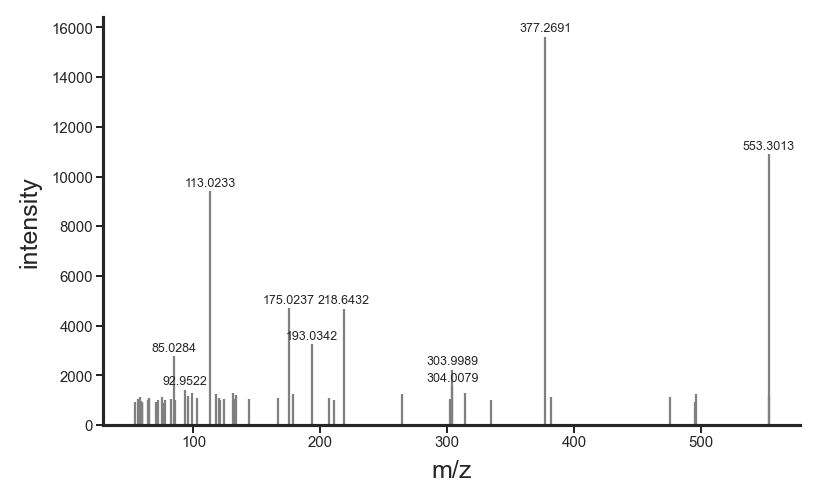

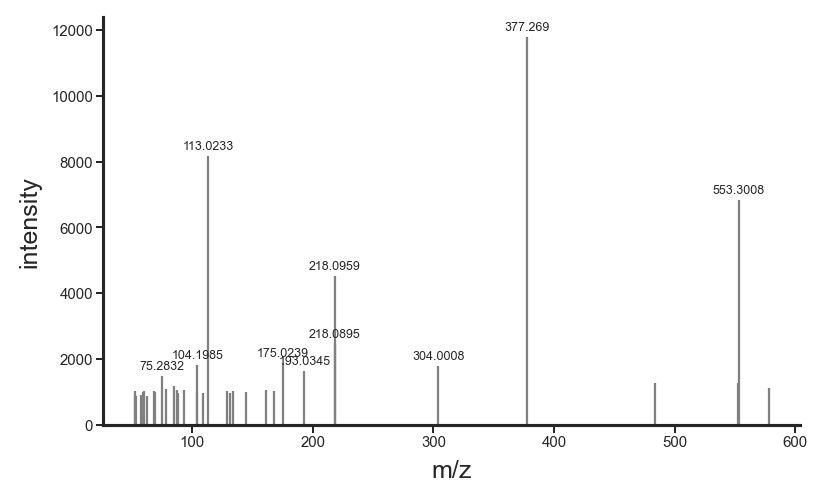

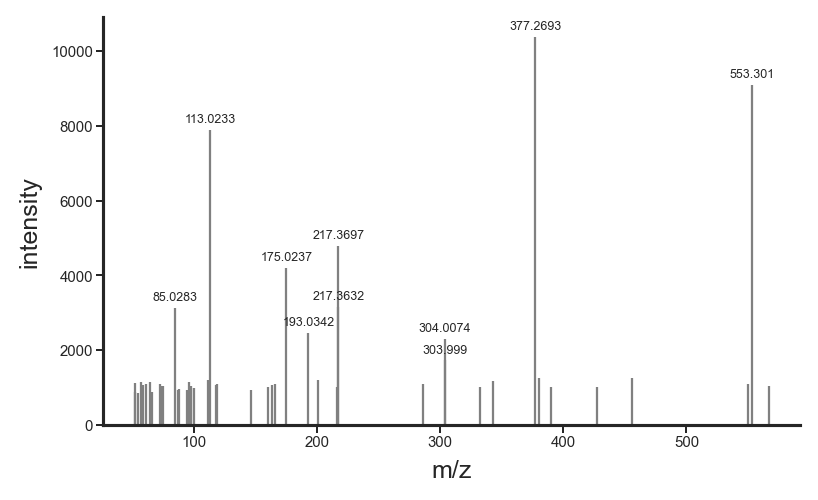

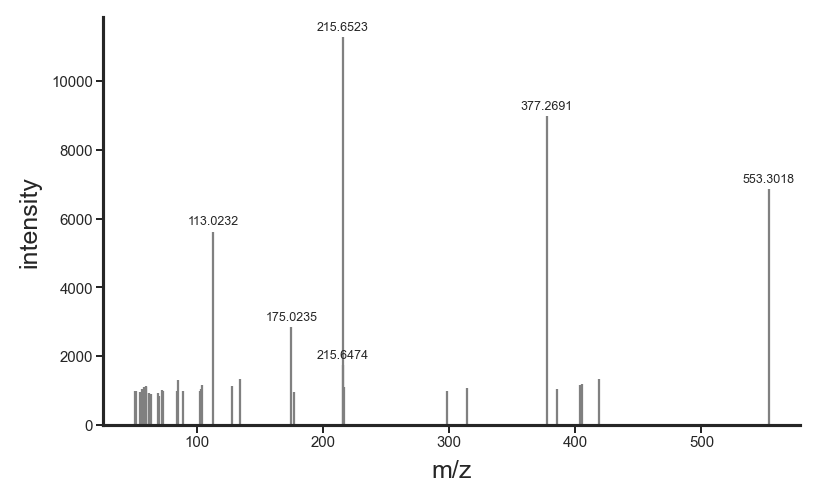

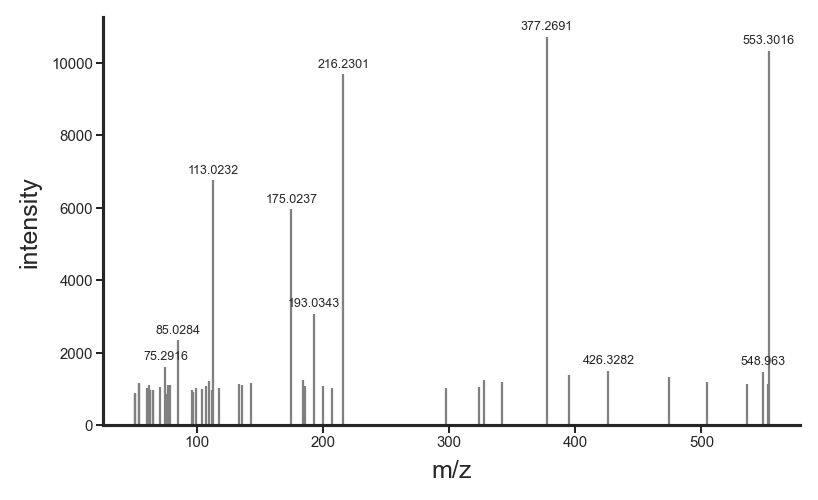

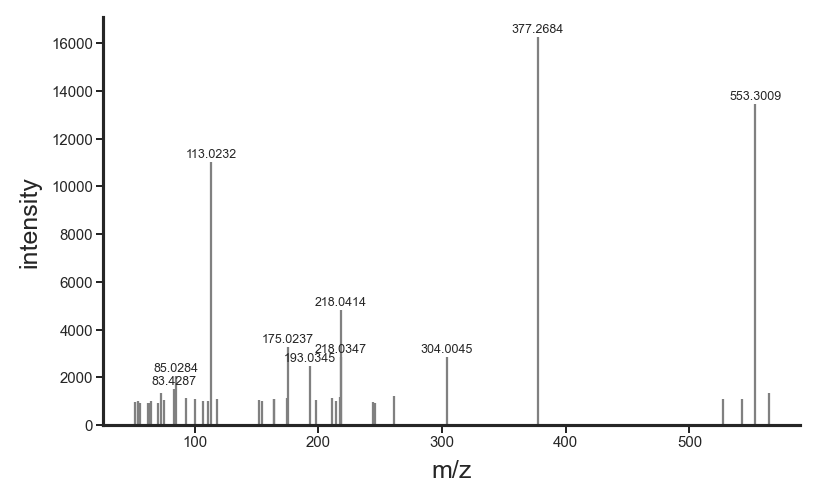

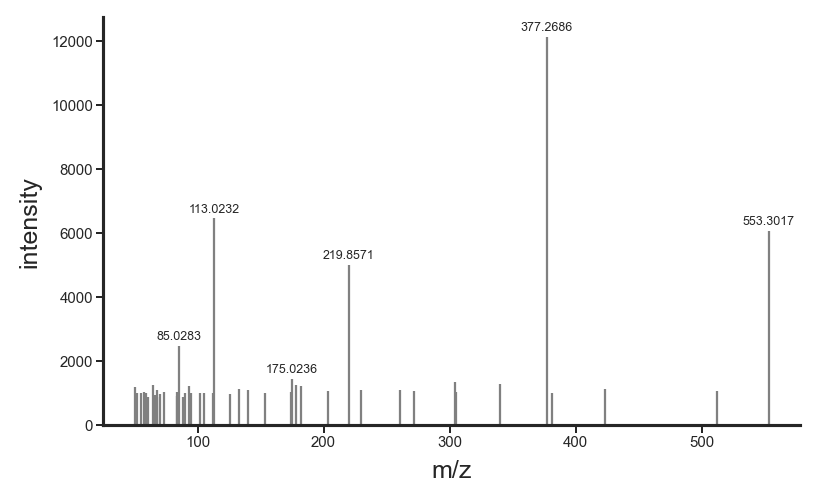

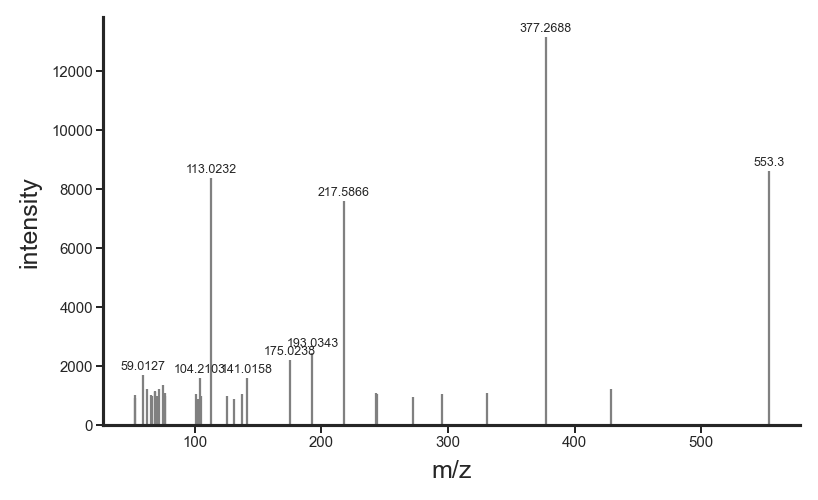

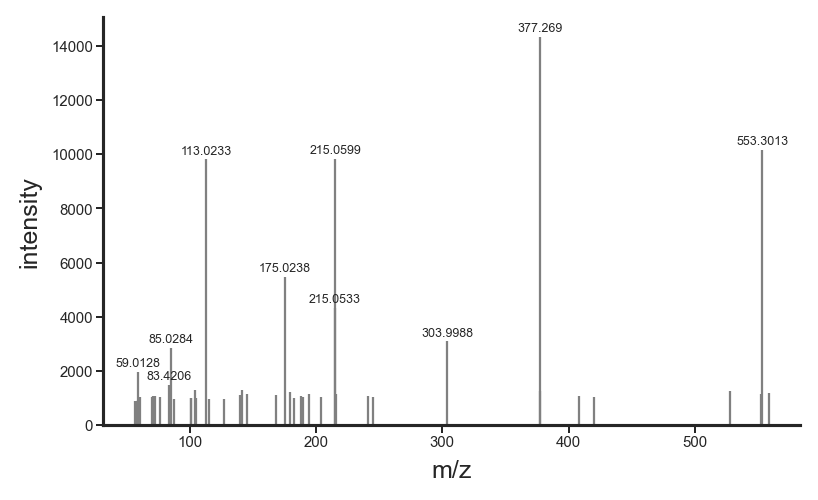

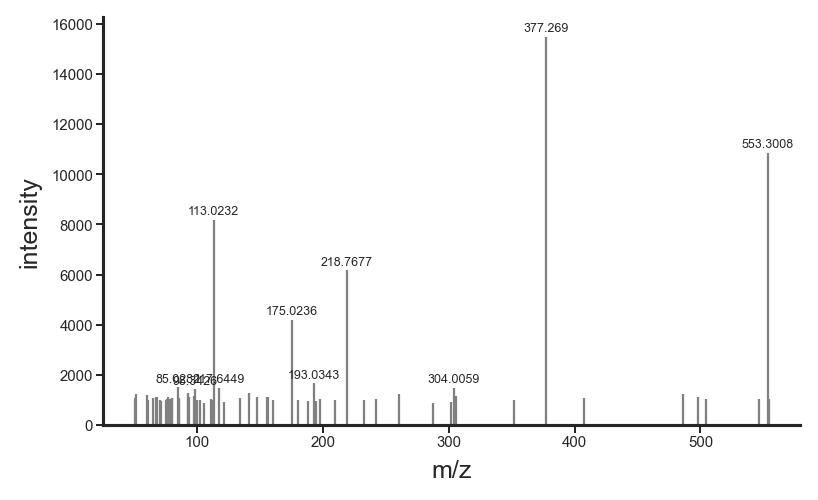

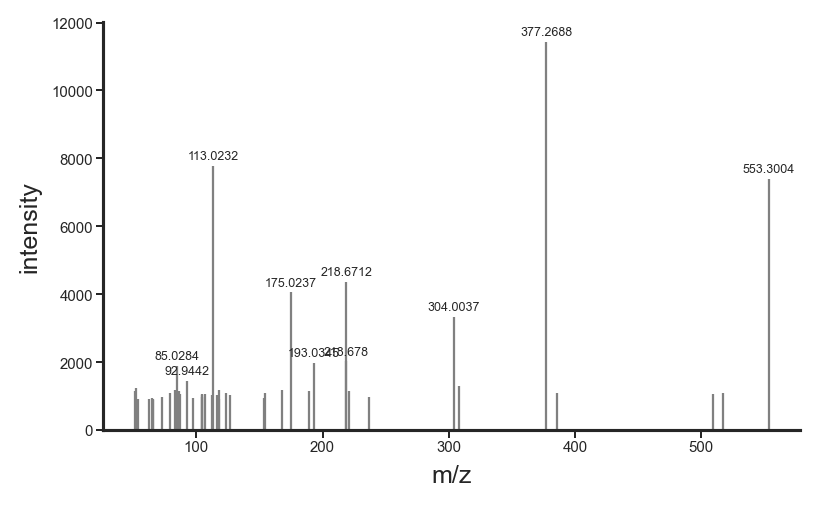

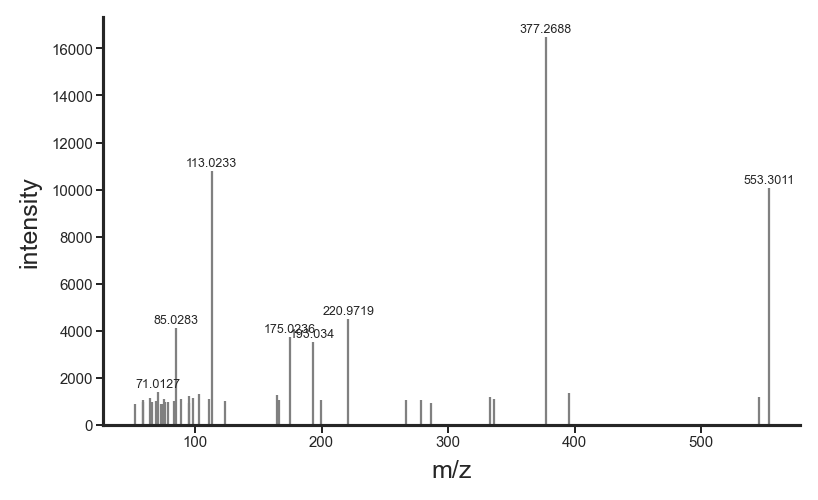

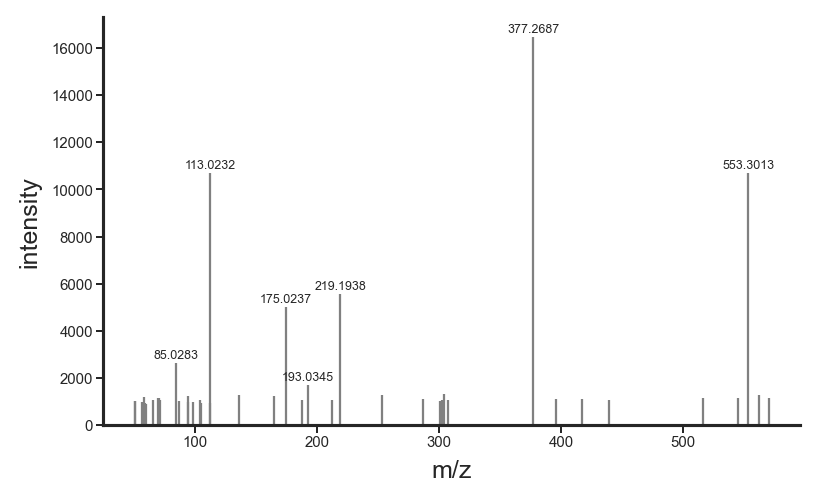

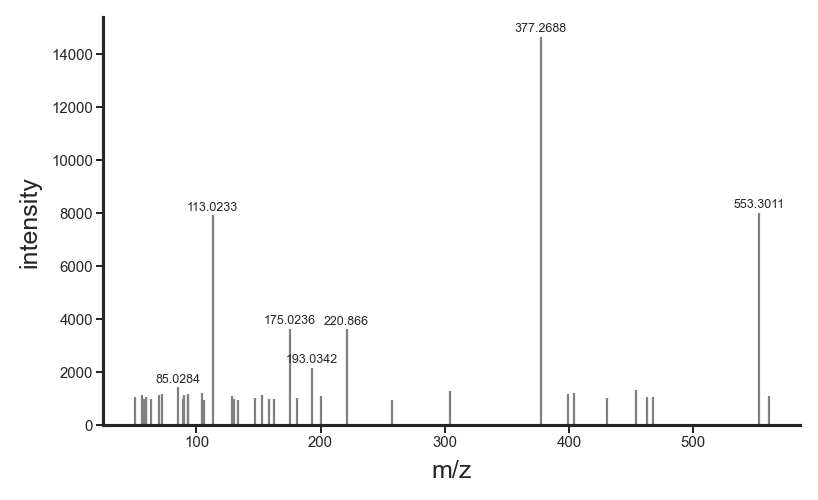

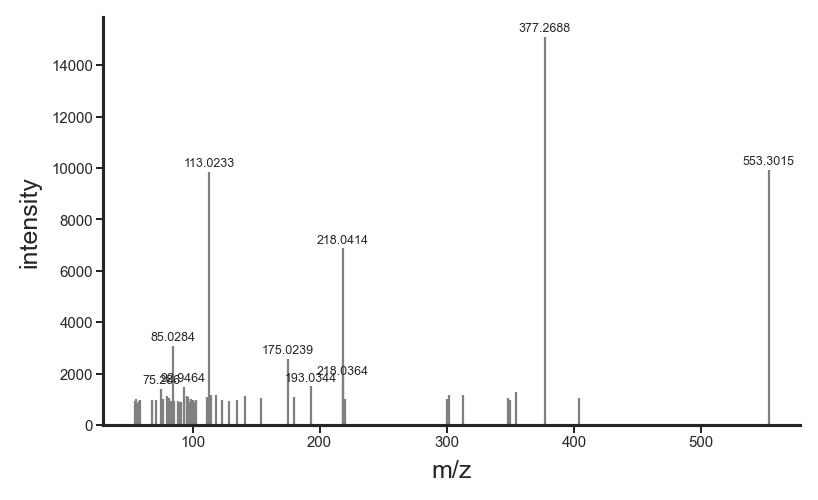

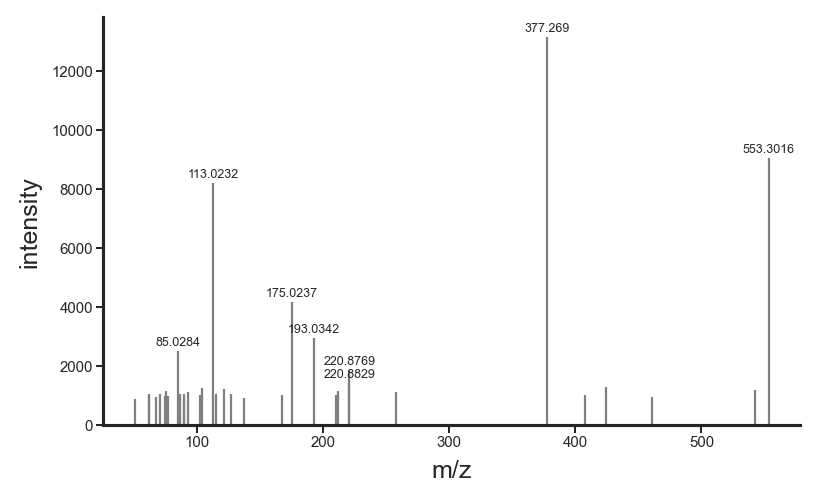

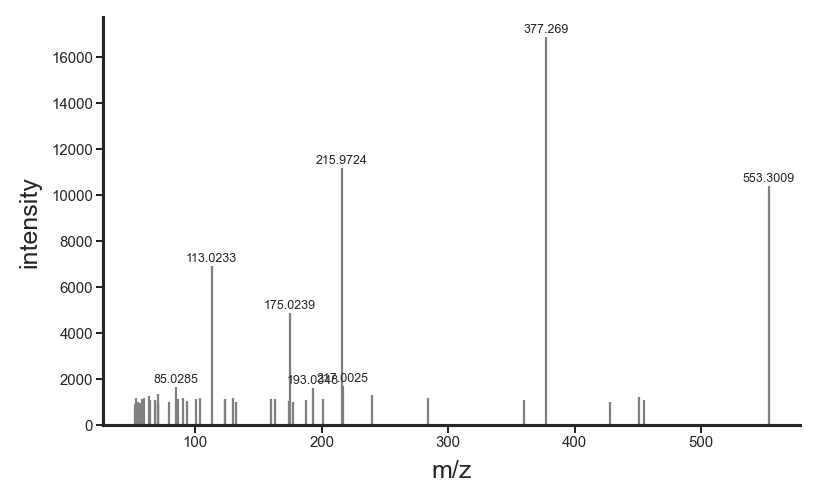

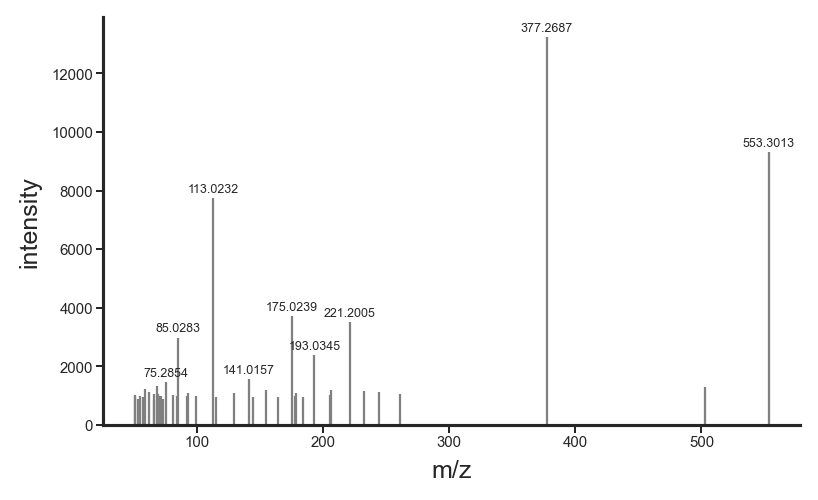

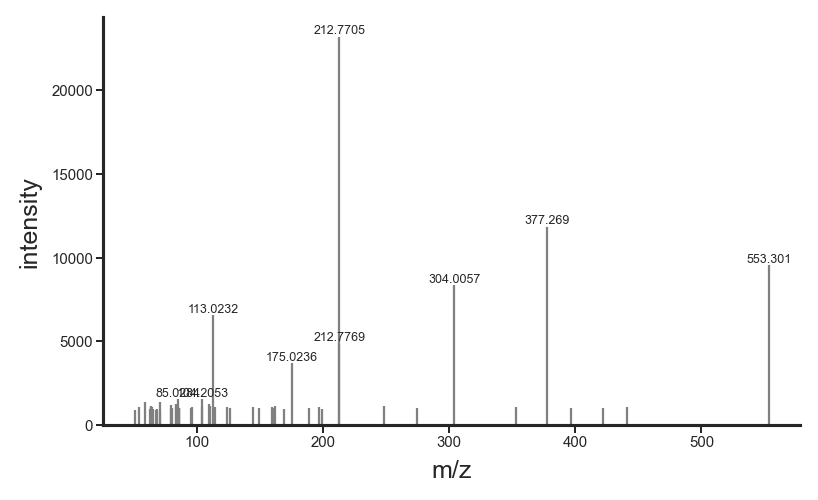

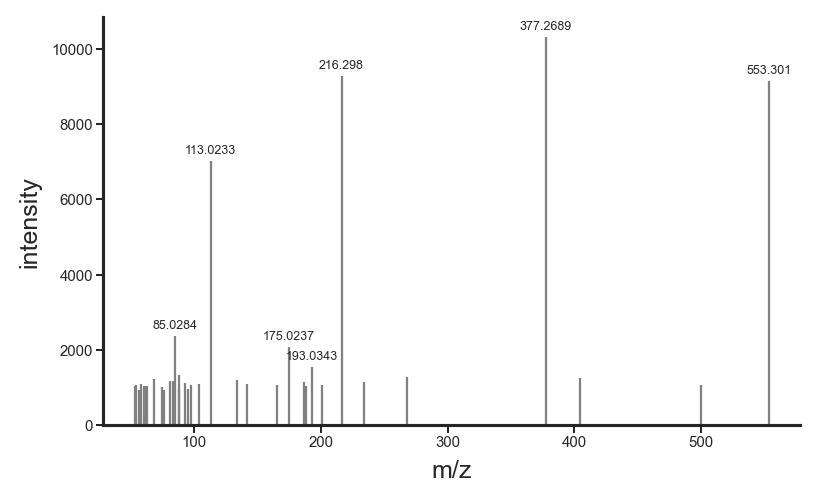

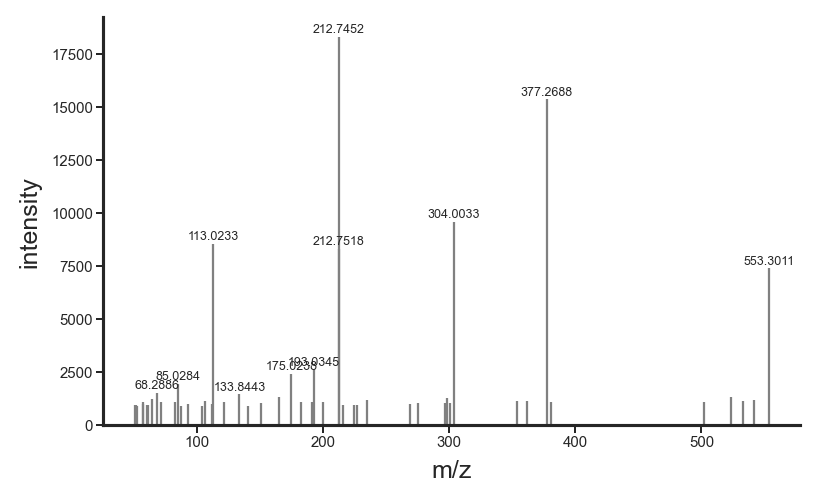

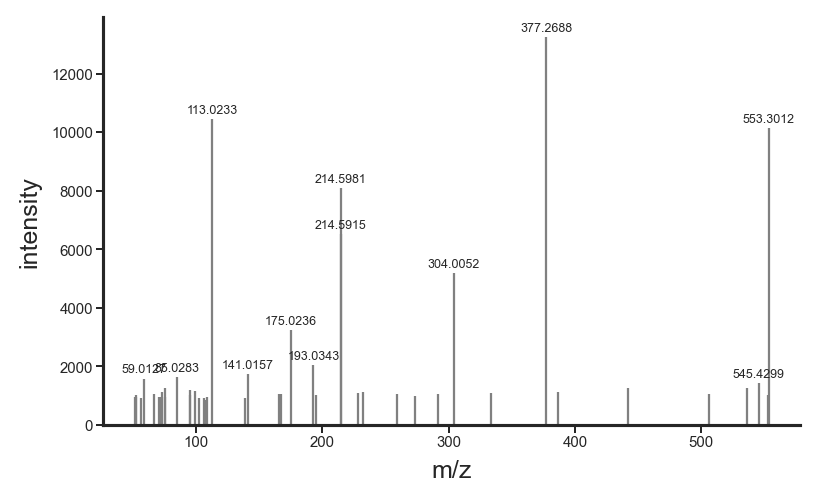

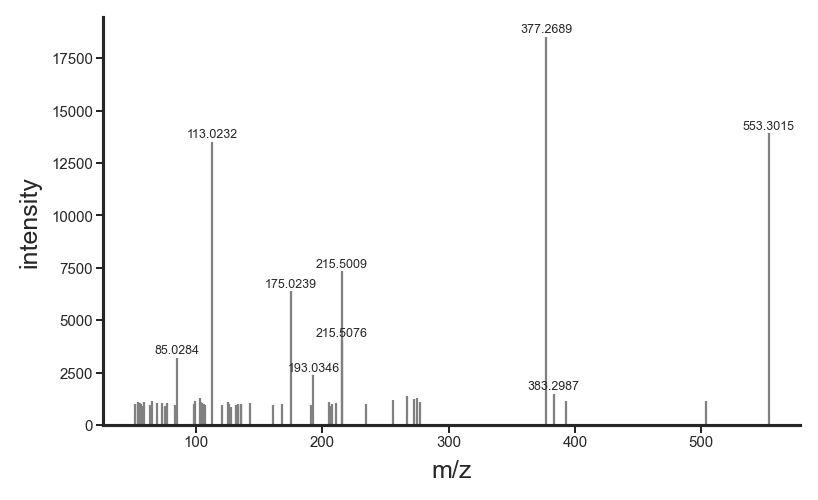

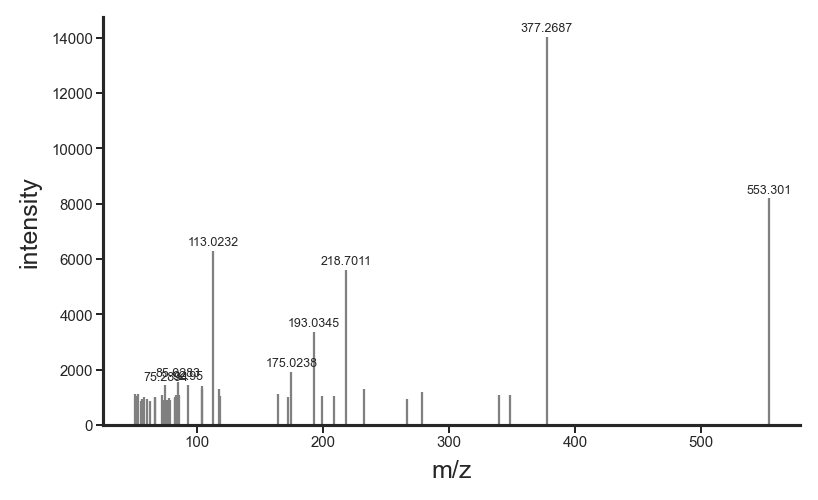

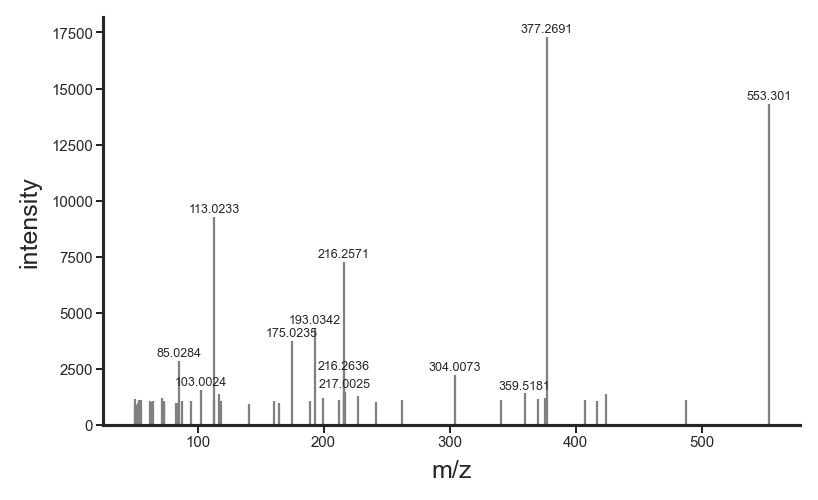

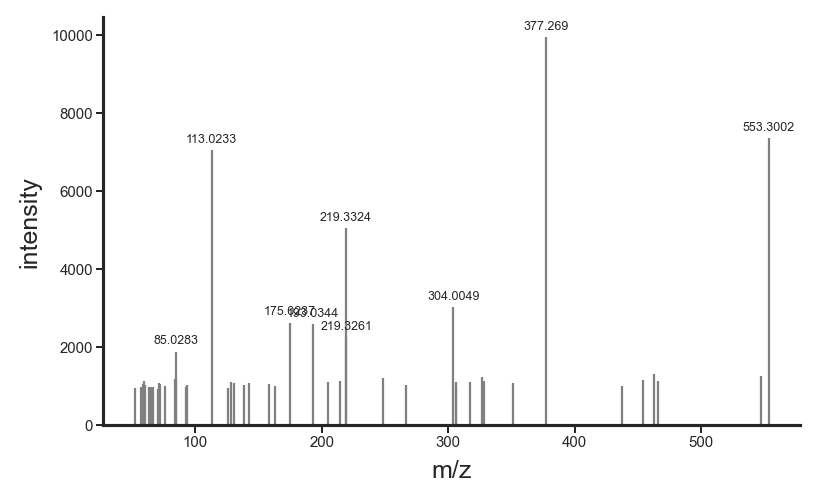

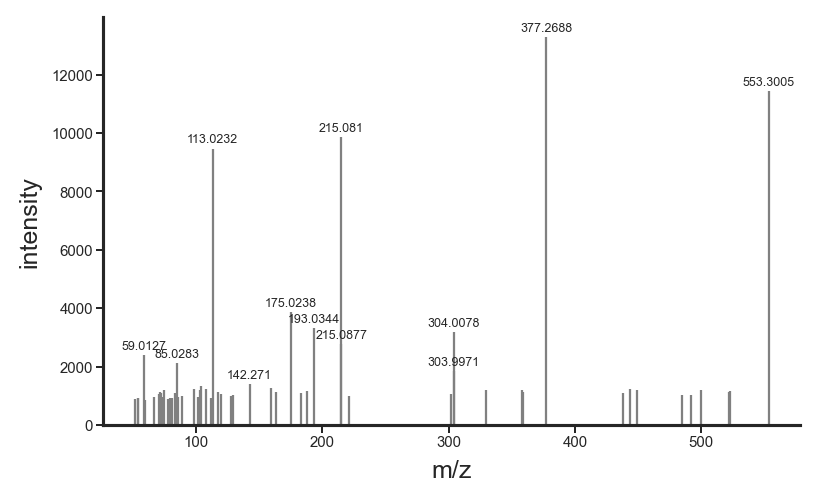

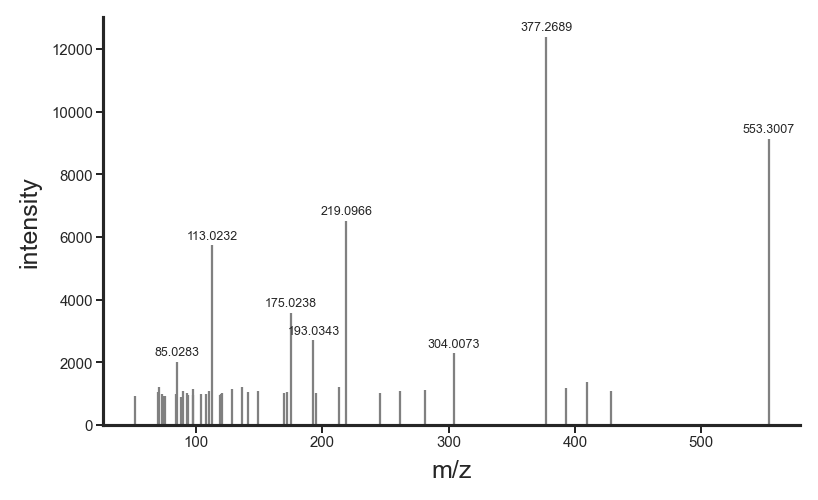

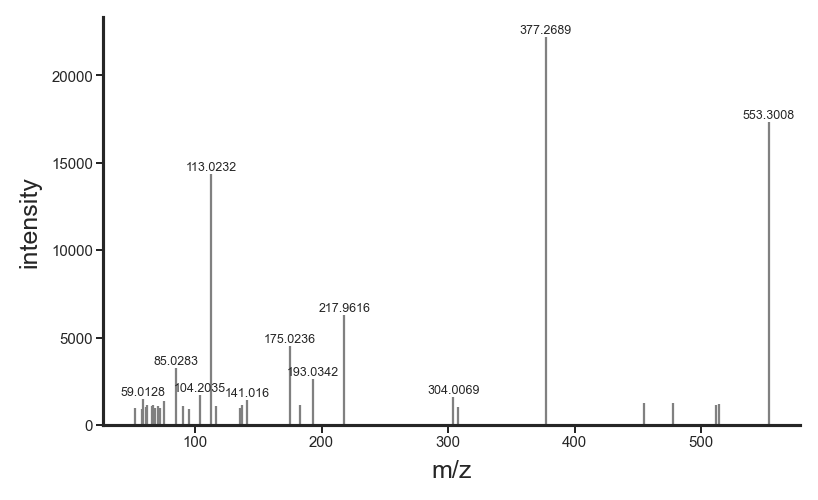

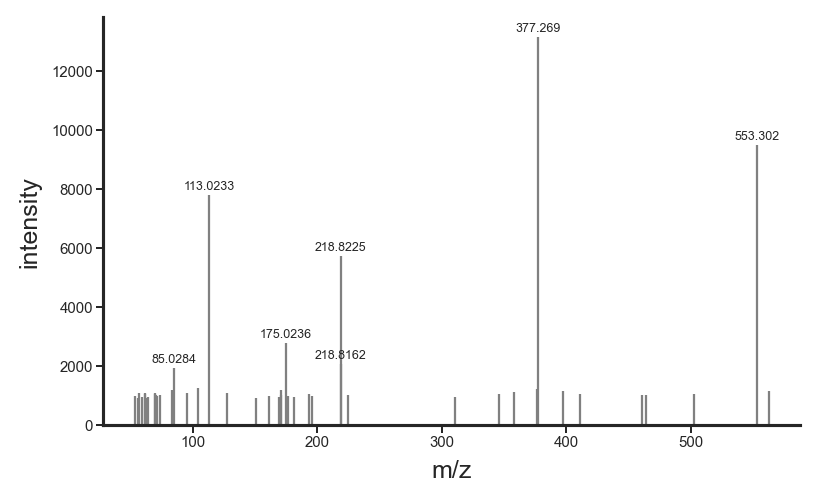

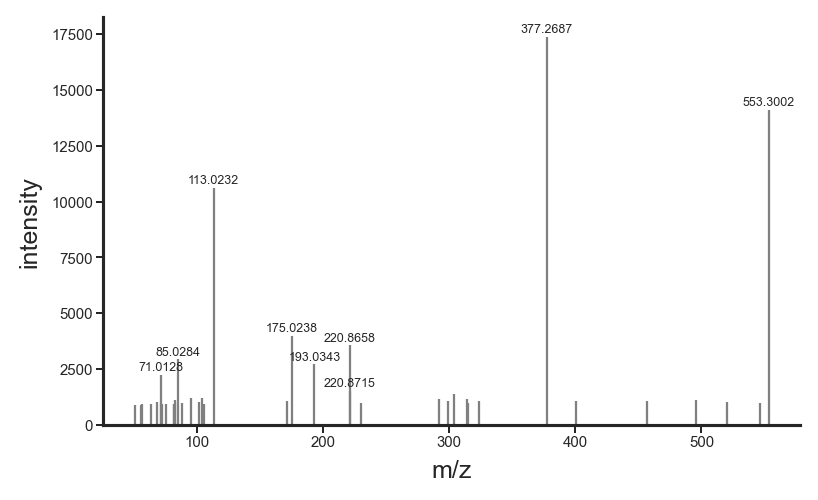

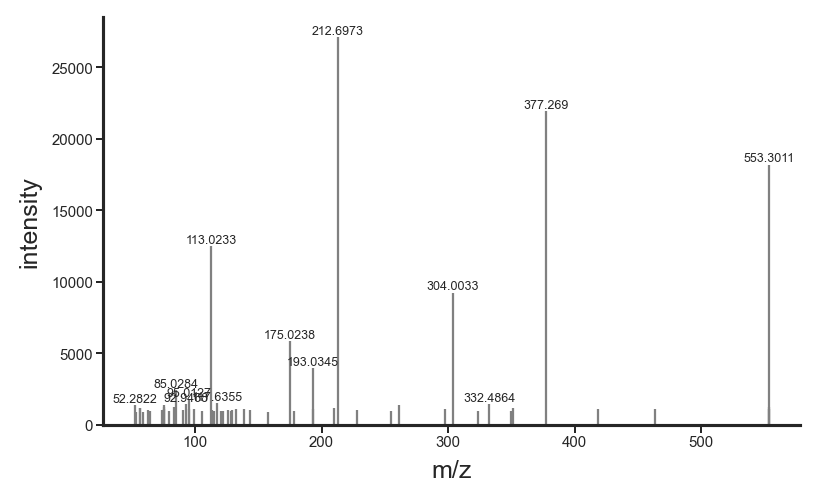

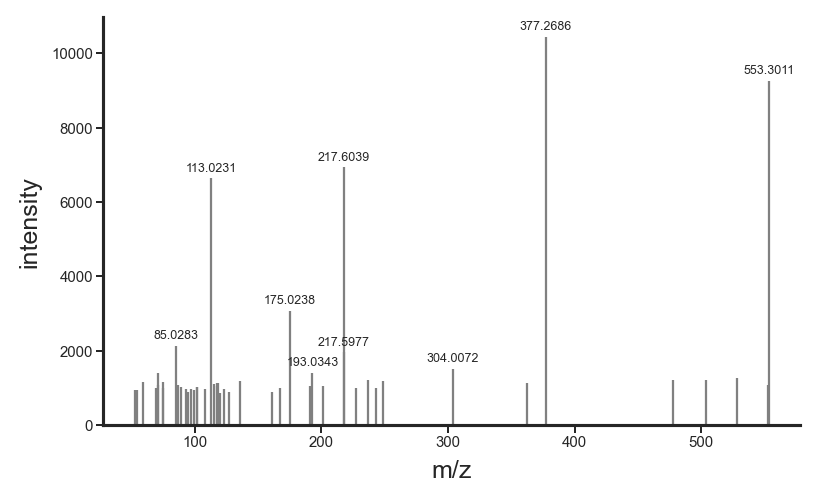

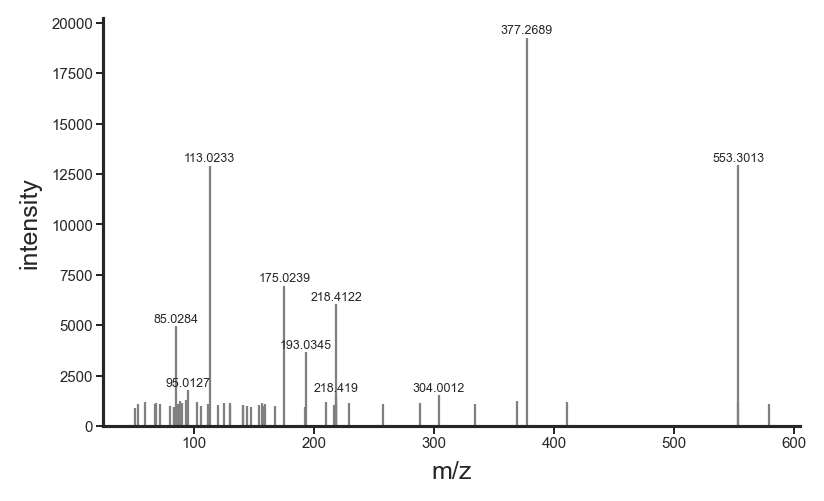

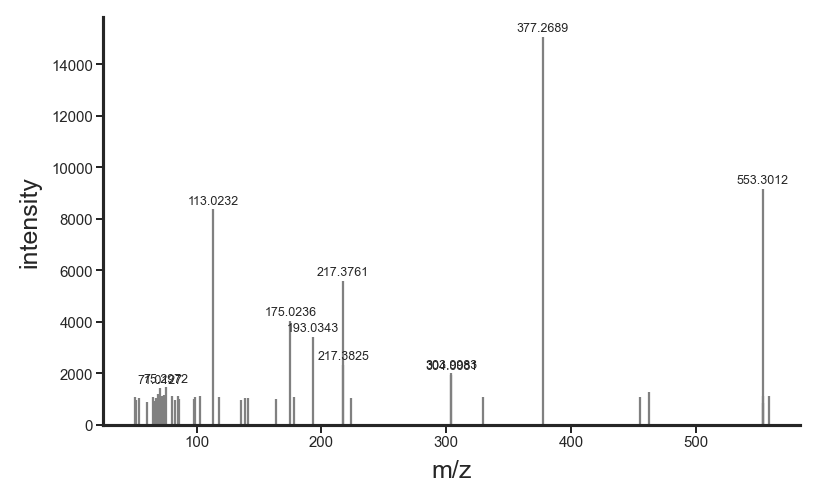

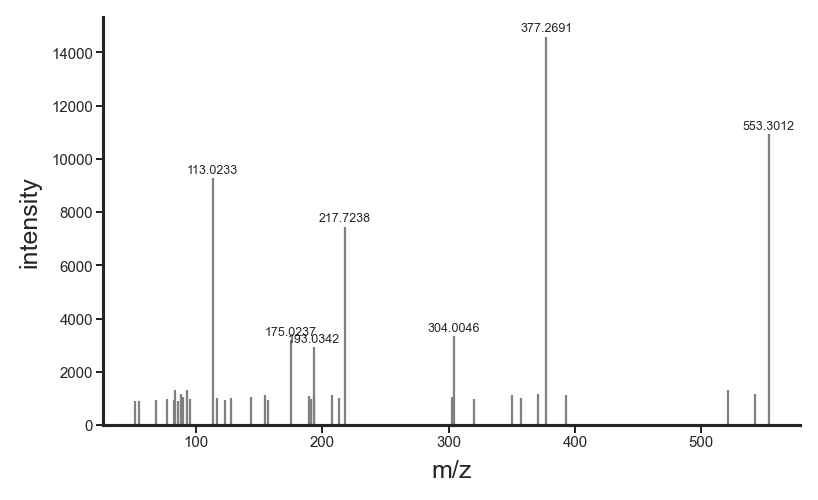

In [180]:
for i, row in r.iterrows():
    print(i)
    f = msfr.MSFileReader(str(row['filepath']))
    spec = f.GetMassListFromScanNum(row['scan'])[0]
    noise = f.GetNoiseData(row['scan'])
    
  
    
    plt.figure(figsize=(5,3), dpi=180)
    markerline, stemlines, baseline = plt.stem(spec[0], spec[1], markerfmt='none')
    plt.setp(stemlines, 'linewidth', 0.9)
    plt.setp(stemlines, 'color', 'gray')
    plt.setp(baseline, 'linewidth', 0)
    plt.ylim(bottom=0)
    for mz, intensity in zip(spec[0], spec[1]):
        if intensity > 1400:
            plt.text(mz, intensity+200, round(mz, 4), ha='center', fontsize=5)    
#             print(mz, intensity)
    plt.ylabel('intensity')
    plt.xlabel('m/z')
    plt.tick_params(length=3, pad=1, labelsize=6)
    sns.despine()
    


In [135]:
from pyteomics import mass
import spectrum_utils as su
import spectrum_utils.spectrum as sus

from itertools import combinations, permutations

In [147]:
for combo in permutations('LLFY', 4):
    combo = ''.join(combo)
    ms2 = sus.MsmsSpectrum('LLFY', row['mz'], -1, mz=spec[0], intensity=spec[1], peptide=combo)
    anno = ms2.annotate_peptide_fragments(0.3, 'Da', 'abcxyz', peak_assignment='most_intense')
    print('\n', combo, '\n', )
    display([x for x in anno.annotation if x is not None])
    




 LLFY 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778)]


 LLYF 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 LFLY 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778)]


 LFYL 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 LYLF 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 LYFL 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 LLFY 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778)]


 LLYF 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 LFLY 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778)]


 LFYL 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 LYLF 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 LYFL 



[PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
 PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 FLLY 



[]


 FLYL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 FLLY 



[]


 FLYL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 FYLL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 FYLL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 YLLF 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 YLFL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 YLLF 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=166.08625115047002)]


 YLFL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 YFLL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]


 YFLL 



[PeptideFragmentAnnotation(ion_type='y', ion_index=1, charge=1, mz=132.10190115047)]

In [131]:
anno.annotation

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None,
       PeptideFragmentAnnotation(ion_type='a', ion_index=1, charge=1, mz=86.09642184721001),
       None, None, None, None, None, None, None, None, None,
       PeptideFragmentAnnotation(ion_type='c', ion_index=1, charge=1, mz=131.11788556778),
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None], dtype=object)

In [110]:
mass.calculate_mass(sequence='LLYF')

554.3104350835

In [101]:
help(pyteomics)

Help on package pyteomics:

NAME
    pyteomics

PACKAGE CONTENTS
    _schema_defaults
    achrom
    auxiliary (package)
    electrochem
    fasta
    mass (package)
    mgf
    ms1
    ms2
    mzid
    mzml
    mztab
    mzxml
    openms (package)
    parser
    peff
    pepxml
    protxml
    pylab_aux
    tandem
    traml
    usi
    version
    xml

FILE
    (built-in)




In [99]:
113+18

131

In [55]:
# for mass, noise_, baseline in zip(*noise):
#     print(mass, noise_, baseline)

In [83]:
stemlines.set_colors

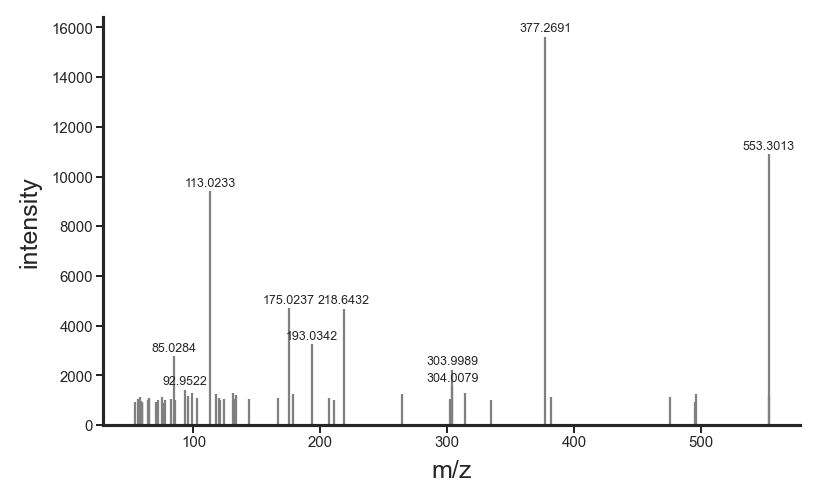

In [96]:

plt.figure(figsize=(5,3), dpi=180)
markerline, stemlines, baseline = plt.stem(spec[0], spec[1], markerfmt='none')
plt.setp(stemlines, 'linewidth', 0.9)
plt.setp(stemlines, 'color', 'gray')
plt.setp(baseline, 'linewidth', 0)
plt.ylim(bottom=0)
for mz, intensity in zip(spec[0], spec[1]):
    if intensity > 1400:
        plt.text(mz, intensity+200, round(mz, 4), ha='center', fontsize=5)    
plt.ylabel('intensity')
plt.xlabel('m/z')
plt.tick_params(length=3, pad=1, labelsize=6)
sns.despine()

In [91]:
553.3013 - 377.2691

176.0322

In [92]:
377.27 - 175.02

202.24999999999997

In [148]:
help(f)

Help on MSFileReader in module pymsfilereader.MSFileReader object:

class MSFileReader(builtins.object)
 |  MSFileReader(filename, **kwargs)
 |  
 |  # noinspection PyPep8Naming
 |  
 |  Methods defined here:
 |  
 |  Close(self)
 |      Closes a raw file and frees the associated memory.
 |  
 |  ExtractInstMethodFromRaw(self, instMethodFileName)
 |      This function enables you to save the embedded instrument method in the raw file in a
 |      separated method (.meth)) file. It overwrites any pre-existing method file in the same path
 |      with the same name.
 |  
 |  GetAValueFromScanNum(self, scanNumber)
 |      This function gets the A parameter value in the scan event. The value returned is either 0, 1,
 |      or 2 for parameter A off, parameter A on, or accept any parameter A, respectively.
 |  
 |  GetAcquisitionDate(self)
 |      Returns the acquisition date for the current controller. This value is typically only set for raw
 |      files converted from other file formats

In [173]:
f.GetPrecursorInfoFromScanNum(1007)

In [176]:
f.GetScanEventForScanNum(1140)

'FTMS + ESI !sid d AMI Full ms2 100.1125@30.00 iw 1.00000 hcd@30.00 [50.0000-120.0000]'